In [1]:
import json
import numpy as np
import shutil
import glob
from tqdm import tqdm
import pandas as pd
import unidecode
import os
import subprocess
import  tarfile
import xml.etree.ElementTree as ET
import ast
import zipfile
import datetime

# Filtering with word "nation"

In [2]:
os.makedirs('/scratch/students/antoun/figaro_words/nation/filtered_nation', exist_ok=True)

In [3]:
# Traverse all JSON files
json_count = 0
filter_count = 0
for root, dirs, files in os.walk('/scratch/students/antoun/corpus/le_figaro'):
    for file_name in files:
        if file_name.endswith('.json'):
            with open(os.path.join(root, file_name)) as json_file:
                json_text = json.load(json_file)
                json_count += 1
        
        #check if "nation" is in file
                if "nation" in json.dumps(json_text):
            # Copy file in filtered file directoy
                    shutil.copyfile(os.path.join(root, file_name), os.path.join('/scratch/students/antoun/figaro_words/nation/filtered_nation', file_name))
                    filter_count += 1
                
print(f"Found {json_count} JSON files in the directory")
print(f"Found {filter_count} files with the word")
        
        

Found 28503 JSON files in the directory
Found 27946 files with the word


In [6]:
if not os.path.exists("/scratch/students/antoun/figaro_words/nation/data"):
    os.makedirs("/scratch/students/antoun/figaro_words/nation/data")

#Get list of all articles
every_article = glob.glob('/scratch/students/antoun/figaro_words/nation/filtered_nation/*.json')
nation_articles = pd.DataFrame(columns=["publication_date", "content"])
dates_fr = set()
for article in tqdm(every_article):
    date = article.split("/")[-1][:10] #ask
    dates_fr.add(date)
    with open(article, 'r') as f:
        data = json.load(f)   
        if "nation" in unidecode.unidecode(str.lower(data["contentAsText"][0])):
            nation_articles.loc[date] = {"publication_date" : date, "content":data["contentAsText"][0]}
            #length = len(content)
            #avenir_articles.loc[date] = {"publication_date": date, "content": content, "length": length}

            
            
#sort data by publication date
nation_articles.sort_values(by = ["publication_date"], inplace =True)

#save the data
nation_articles.to_csv("/scratch/students/antoun/figaro_words/nation/filtered_nation.csv")

# Save dates
with open('/scratch/students/antoun/figaro_words/nation/data/dates_fr.txt','w') as f:
    f.write(str(dates_fr))
    
#sort the dates
with open('/scratch/students/antoun/figaro_words/nation/data/dates_fr.txt', 'w') as f:
# parse dates as datetime objects and sort them
    dates_fr_sorted = sorted([datetime.datetime.strptime(date, '%Y%m%d.m') for date in dates_fr])
    # convert datetime objects back to strings in the desired format and write them to file
    f.write('\n'.join([date.strftime('%Y%m%d.m') for date in dates_fr_sorted]))
    
# calculate average length of articles
#avg_length = avenir_articles["length"].mean()

# print the result
#print("Average article length:", avg_length)

    

100%|██████████████████████████████████████████████████████| 27946/27946 [06:11<00:00, 75.29it/s]


## raw frequency of "nation"

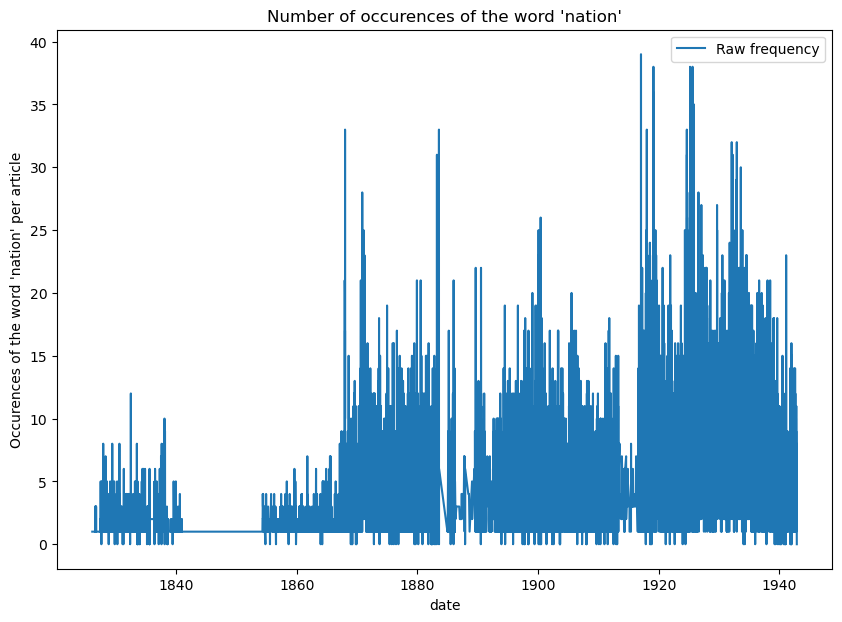

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv("/scratch/students/antoun/figaro_words/nation/filtered_nation.csv")
df = df.sort_values(by = "publication_date")

#convert column "piblication_date" from string to date time format
df["publication_date"] = pd.to_datetime(df["publication_date"], format = "%Y%m%d.m").dt.date

#set index to piblication date column
df = df.set_index("publication_date")
x = np.arange(len(df))

#function that counts raw frequency
def count_word_frequency(word, text):
    return text.count(word)

word = "nation"
df["frequency"] = df["content"].apply(lambda x: count_word_frequency(word, x))



y = df["frequency"]
degree = 10
coeffs = np.polyfit(x, y, degree)
frequencies_polyfit = np.polyval(coeffs, x)

#plot
plt.figure(figsize=(10,7))
plt.plot(df.index, df["frequency"], label = "Raw frequency")
plt.title("Number of occurences of the word 'nation'")
plt.xlabel("date")
plt.ylabel("Occurences of the word 'nation' per article")
plt.legend()
plt.show()

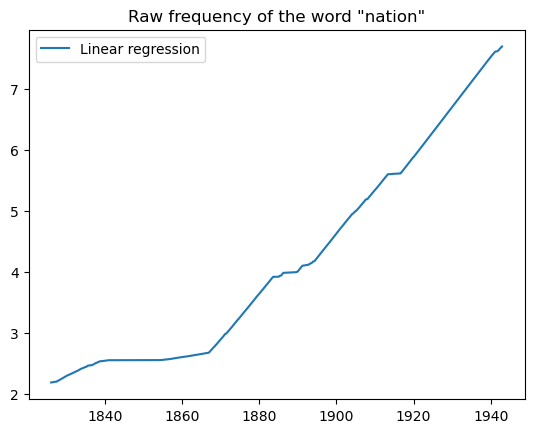

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv("/scratch/students/antoun/figaro_words/nation/filtered_nation.csv")
df = df.sort_values(by = "publication_date")

#convert column "piblication_date" from string to date time format
df["publication_date"] = pd.to_datetime(df["publication_date"], format = "%Y%m%d.m").dt.date

#set index to piblication date column
df = df.set_index("publication_date")

#function that counts raw frequency
def count_word_frequency(word, text):
    return text.count(word)

word = "nation"
df["frequency"] = df["content"].apply(lambda x: count_word_frequency(word, x))



model = LinearRegression()
x = np.arange(len(df)).reshape(-1, 1)
y = df['frequency'].values.reshape(-1, 1)
model.fit(x, y)

plt.plot(df.index, model.predict(x), label = "Linear regression")
plt.title('Raw frequency of the word "nation"')
plt.legend()
plt.show()

# Dividing dates into blocks

In [2]:
import nltk 
nltk.download('punkt')
from nltk import ngrams
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

[nltk_data] Downloading package punkt to /home/tamantoun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the CSV file into a pandas data frame
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("/scratch/students/antoun/figaro_words/nation/filtered_nation.csv")

df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y%m%d.m').dt.date

# Define the date ranges
range0 = (datetime.datetime.strptime('18260101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18401231.m', '%Y%m%d.m').date())

range1 = (datetime.datetime.strptime('18400101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18601231.m', '%Y%m%d.m').date())

range2 = (datetime.datetime.strptime('18600101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18801231.m', '%Y%m%d.m').date())

range3 = (datetime.datetime.strptime('18800101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19001231.m', '%Y%m%d.m').date())

range4 = (datetime.datetime.strptime('19000101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19201231.m', '%Y%m%d.m').date())

# Open the file and read the dates
with open('/scratch/students/antoun/figaro_words/nation/data/dates_fr.txt', 'r') as f:
    dates = f.read().splitlines()

# Convert the dates to date objects
dates = [datetime.datetime.strptime(date, '%Y%m%d.m').date() for date in dates]

block0 =  df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range0[0], range0[1])]
new_value0 = block0["content"].apply(nltk.word_tokenize) 
block0.loc[:, "tokens"] =  new_value0

block1 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range1[0], range1[1])]
new_value1 = block1["content"].apply(nltk.word_tokenize) 
block1.loc[:, "tokens"] =  new_value1

block2 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range2[0], range2[1])]
new_value2 = block2["content"].apply(nltk.word_tokenize) 
block2.loc[:, "tokens"] =  new_value2

block3 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range3[0], range3[1])]
new_value3 = block3["content"].apply(nltk.word_tokenize) 
block3.loc[:, "tokens"] =  new_value3

block4 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range4[0], range4[1])]
new_value4 = block4["content"].apply(nltk.word_tokenize) 
block4.loc[:, "tokens"] =  new_value4

# Print the number of dates in each block
print(f"Block 0 ({range0[0]} - {range0[1]}): {len(block0)} dates")
print(f"Block 1 ({range1[0]} - {range1[1]}): {len(block1)} dates")
print(f"Block 2 ({range2[0]} - {range2[1]}): {len(block2)} dates")
print(f"Block 3 ({range3[0]} - {range3[1]}): {len(block3)} dates")
print(f"Block 4 ({range4[0]} - {range4[1]}): {len(block4)} dates")

KeyboardInterrupt: 

## Block 1

In [5]:
import string
punctuations = string.punctuation

### 2-grams before

In [6]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_1_before = []

for doc in block1["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i > 1:
                two_grams_block_1_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_1_before = FreqDist(two_grams_block_1_before)


with open("/scratch/students/antoun/figaro_words/nation/texts/nation_before1.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_1-----------------------Two-grams before 'nation':\n")
    for two_gram in two_grams_block_1_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 1 (1840-1860): \n")
print(f"2-grams before 'nation': \n")
print(two_grams_block_1_before, "\n")

print("Most common 2-grams before 'nation': \n")
print(freq_dist_block_1_before.most_common(), "\n")


Block 1 (1840-1860): 

2-grams before 'nation': 

[('de', 'la'), ('que', 'la'), ('de', 'sa'), ("l'histoire", "d'une"), ('de', 'la'), ('caractérisé', 'notre'), ('|de', 'toute'), ('à', "l'imagi"), ('de', "l'imagi"), ('enfouit', 'une'), ('de', 'votre'), ('est', 'une'), ('de', 'la'), ('pour', 'la'), ('Pure', 'imagi'), ('homme', "d'imagi"), ("l'armée", 'devint'), ('et', 'la'), ('de', 'la'), ('une', 'grande'), ('—', 'votre'), ('une', 'grande'), ('de', 'la'), ('de', 'la'), ('porte', 'sa'), ('de', 'la'), ('puissance', 'la'), ('que', "l'imagi"), ('d', 'une'), ('de', 'la'), ('que', "l'imagi"), ('nations', 'la'), ('peuple', 'La'), ('que', 'la'), ('déteste', 'La'), ('enthousiasme', 'la'), ("c'est", 'la'), ('de', 'la'), ('sa', 'nomi'), ('auquel', "l'imagi-"), ('de', 'la'), ('chez', 'notre')] 

Most common 2-grams before 'nation': 

[(('de', 'la'), 10), (('que', 'la'), 2), (('une', 'grande'), 2), (('que', "l'imagi"), 2), (('de', 'sa'), 1), (("l'histoire", "d'une"), 1), (('caractérisé', 'notre'), 1),

### 2-grams after

In [7]:
two_grams_block_1_after = []

for doc in block1["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i < len(doc)-3:
                two_grams_block_1_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_1_after = FreqDist(two_grams_block_1_after)

with open("/scratch/students/antoun/figaro_words/nation/texts/nation_after1.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_1-----------------------Two-grams after 'nation':\n")
    for two_gram in two_grams_block_1_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'nation': \n")
print(two_grams_block_1_after, "\n")

print("Most common 2-grams after 'nation': \n")
print(freq_dist_block_1_after.most_common())

2-grams after 'nation': 

[('qui', 'a'), ('adopterait', 'et'), ('Un', 'de'), ('écrite', 'avec'), ('triompha', 'un'), ("—J'ai", 'lu'), ('de', 'toute'), ('toutes', 'les'), ('que', 'les'), ('je', 'suis'), ('et', 'nous'), ('de', 'Décius'), ('les', 'anecdotes'), ('de', 'ces'), ('que', 'tout'), ('donne', 'quelquefois'), ('et', 'la'), ('finit', 'par'), ('superbe', 'qui'), ('dont', 'il'), ('est', 'une'), ('et', 'si'), ('y', 'est'), ('—', 'et'), ('à', 'un'), ('comme', 'en'), ('retrouve', 'alors'), ('et', 'le'), ('où', 'elle'), ('sa', 'vitalité'), ('peut', 'créer'), ('officielle', 'et'), ('officiélie', 'et'), ('officielle', 'nous'), ('officielle', 'nous'), ('officielle', 'les'), ('Dis-moi', 'ce'), ('édifice', "d'utilité"), ('a', 'été'), ('la', 'plus'), ('mais', 'il'), ('capricieuse', 'et')] 

Most common 2-grams after 'nation': 

[(('officielle', 'nous'), 2), (('qui', 'a'), 1), (('adopterait', 'et'), 1), (('Un', 'de'), 1), (('écrite', 'avec'), 1), (('triompha', 'un'), 1), (("—J'ai", 'lu'), 1), (

## Block 2

### 2-grams before

In [8]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_2_before = []

for doc in block2["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i > 1:
                two_grams_block_2_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_2_before = FreqDist(two_grams_block_2_before)


with open("/scratch/students/antoun/figaro_words/nation/texts/nation_before2.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_2-----------------------Two-grams before 'nation':\n")
    for two_gram in two_grams_block_2_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 2 (1860-1880): \n")
print(f"2-grams before 'nation': \n")
print(two_grams_block_2_before, "\n")

print("Most common 2-grams before 'nation': \n")
print(freq_dist_block_2_before.most_common(), "\n")



Block 2 (1860-1880): 

2-grams before 'nation': 

[('auquel', "l'imagi-"), ('de', 'la'), ('chez', 'notre'), ('et', "l'imagi"), ('sur', 'une'), ('fonds', 'la'), ('demandés', 'La'), ('à', 'voire'), ('»', 'Notre'), ('frais', "d'imagi"), ('moralité', "d'une"), ('ma', 'condam'), ('son', 'imagi'), ('de', 'la'), ('Mon', 'imagi'), ('de', 'la'), ('une', 'imagi'), ('de', 'la'), ('notre', 'pauvre'), ('do', 'la'), ('un', 'e'), ('de', 'la'), ('Dans', 'une'), ('ma', 'condam'), ('—', 'La'), ('supérieure', 'aucune'), ('de', 'la'), ('de', 'la'), ('de', 'la'), ('de', 'la'), ('partie', "d'une"), ('appelle', 'la'), ('son', 'imagi'), ('de', 'sa'), ('de', 'sa'), ('mais', 'une'), ('dignité', "d'une"), ('comme', 'une'), ('fortune', "d'une"), ('la', 'première'), ('intéressent', 'la-'), ('de', 'la'), ('condam-', "''"), ('de', 'la'), ('contre', 'la'), ('Une', 'autre'), ('jour', 'cette'), ('mais', 'la'), ('que', 'la'), ('graves', 'une'), ('sauver', 'la'), ('de', 'la'), ('la', 'profa'), ('accumulées', 'chaque'), (

### 2-grams after

In [9]:
two_grams_block_2_after = []

for doc in block2["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i < len(doc)-3:
                two_grams_block_2_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_2_after = FreqDist(two_grams_block_2_after)

with open("/scratch/students/antoun/figaro_words/nation/texts/nation_after2.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_2-----------------------Two-grams after 'nation':\n")
    for two_gram in two_grams_block_2_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'nation': \n")
print(two_grams_block_2_after, "\n")

print("Most common 2-grams after 'nation': \n")
print(freq_dist_block_2_after.most_common())

2-grams after 'nation': 

[('la', 'plus'), ('mais', 'il'), ('capricieuse', 'et'), ('apportée', 'par'), ('sur', 'un'), ('est', 'pauvre'), ("n'était", 'ni'), ('pour', 'solliciter'), ('est', 'de'), ('avait', 'résolu'), ('Ah', 'combien'), ('ne', 'romprait'), ('suggère', 'de'), ('ou', 'de'), ('avait', 'travaillé'), ('dont', 'il'), ('romanesque', 'Ses'), ('n', 'a'), ('les', 'plus'), ('nous', 'les'), ('dans', 'les'), ('mais', 'il'), ('dont', 'les'), ('en', 'elle-même'), ('la', 'loi'), ('ne', 'peut'), ('Du', 'moment'), ('il', 'est'), ("puisqu'il", 'est'), ('A.', 'vrai'), ('se', 'compose'), ('française', 'La'), ('lestée', 'par'), ('de', 'sa'), ('Anglai', "s'il"), ("n'est", 'vraiment'), ('Ce', 'livre'), ('ou', 'comme'), ('vous', 'avouerez'), ('du', 'monde'), ('toute', 'entière'), ('Nous', 'sommes'), ('de', 'Marie'), ('anglaise', 'en'), ('suisse', 'Il'), ('la', 'menace'), ('redoutable', 'et'), ('la', 'plus'), ('française', 'marchait'), ('est', 'toujours'), ('compromise', 'par'), ('la', 'platoniqu

## Block 3

### 2-grams before

In [10]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_3_before = []

for doc in block3["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i > 1:
                two_grams_block_3_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_3_before = FreqDist(two_grams_block_3_before)


with open("/scratch/students/antoun/figaro_words/nation/texts/nation_before3.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_3-----------------------Two-grams before 'nation':\n")
    for two_gram in two_grams_block_3_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 3 (1880-1900): \n")
print(f"2-grams before 'nation': \n")
print(two_grams_block_3_before, "\n")

print("Most common 2-grams before 'nation': \n")
print(freq_dist_block_3_before.most_common(), "\n")




Block 3 (1880-1900): 

2-grams before 'nation': 

[("d'ambassade", "d'une"), ('sa', 'nomi'), ('sur', 'une'), ('la', 'nomi'), ('ou', 'condam'), ('la', 'nomi'), ('de', 'sa'), ('la', 'nomi'), ('à', 'la'), ('de', 'la'), ('do', 'la'), ('pour', 'la'), ('la', 'nomi'), ('une', 'desti'), ('ma', 'nomi'), ('Donnez-lui', 'desti'), ('la', 'nomi'), ('horrible', 'machi'), ('do', 'la'), ('de', 'la'), ('à', 'la'), ('»', 'La'), ('où', 'la'), ('réunir', 'la'), ('divisant', 'la'), ('de', 'la'), ('pas', 'ae'), ('d', "'une"), ('par', 'la'), ('cette', 'nomi'), ('la', 'condam'), ('la', 'nomi'), ('de', 'condam'), ('de', 'la'), ('à', 'une'), ('la', 'domi'), ('sacrés', "d'une"), ('à', 'une'), ('empêchent', 'la'), ('jeunesse', 'la'), ('de', 'la'), ('la', 'condam'), ('pour', 'la'), ("s'agit", "d'une"), ('tant', "d'imagi"), ('la', 'nomi'), ('la', 'nomi'), ('lequel', 'une'), ('de', 'la'), ('aucune', 'récrimi'), ('par', 'la'), ('sa', 'nomi'), ('mariage', "d'incli"), ('la', 'nomi'), ('de', 'la'), ('la', 'condam'), ('s

### 2-grams after

In [11]:
two_grams_block_3_after = []

for doc in block3["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i < len(doc)-3:
                two_grams_block_3_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_3_after = FreqDist(two_grams_block_3_after)

with open("/scratch/students/antoun/figaro_words/nation/texts/nation_after3.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_3-----------------------Two-grams after 'nation':\n")
    for two_gram in two_grams_block_3_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'nation': \n")
print(two_grams_block_3_after, "\n")

print("Most common 2-grams after 'nation': \n")
print(freq_dist_block_3_after.most_common())

2-grams after 'nation': 

[('amie', 'Ces'), ('aurait', 'donné'), ('en', 'particulier'), ('de', 'M.'), ('ces', 'jeunes'), ('de', 'M.'), ('Toutes', 'les'), ('do', 'M.'), ('pour', "s'oppo"), ('et', 'de'), ('quelque', 'nouvelle'), ("qu'elle", 'doit'), ('de', 'trois'), ('encore', 'inconnue'), ('Ils', 'vont'), ('qui', 'ne'), ('comme', 'conseiller'), ('devaient', 'connaître'), ('par', 'le'), ('ni', 'M'), ('sa', 'gloire'), ('allemande', 'lui'), ('no', "s'oc"), ('contre', 'un'), ('quand', 'il'), ('Ainsi', 'le'), ('ou', "l'on"), ('ne', 'peut-quit-'), ('entière', 'et'), ('n', 'a'), ('à', 'six'), ('aux', 'fonctions'), ('»', '»'), ('française', ',lés'), ('de', 'déposer'), ('que', 'M.'), ('qui', 'prétend'), ('si', 'difficile'), ('de', 'sentir'), ('acclamait', 'la'), ('des', 'espérances'), ('de', 'ces'), ('que', 'le'), ('tout', 'entière'), ('La', 'robe'), ("d'unenouvelle", 'commission'), ('de', 'M.'), ('ne', 'sau-'), ('préservées', 'dans'), ("D'après", 'le'), ('française', 'Comment'), ('sera', 'consi

## Block 4

### 2-grams before

In [12]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_4_before = []

for doc in block4["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i > 1:
                two_grams_block_4_before.append((doc[i-2], doc[i-1]))


# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_4_before = FreqDist(two_grams_block_4_before)


with open("/scratch/students/antoun/figaro_words/nation/texts/nation_before4.txt", "w") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_4-----------------------Two-grams before 'nation':\n")
    for two_gram in two_grams_block_4_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 4 (1900-1920): \n")
print(f"2-grams before 'nation': \n")
print(two_grams_block_4_before, "\n")

print("Most common 2-grams before 'nation': \n")
print(freq_dist_block_4_before.most_common(), "\n")

Block 4 (1900-1920): 

2-grams before 'nation': 

[('mais', 'la'), ("d'une", 'même'), ('une', 'petite'), ('de', 'la'), ('une', 'grande'), ('ma', 'condam'), ('que', 'la'), ('auxquels', 'une'), ('Vive', 'la'), ('point', 'de'), ('à', 'la'), ('de', 'cette'), ('Anglais', 'Quelle'), ('et', 'comme'), ('tant', 'que'), ('une', 'grande'), ('mémoire', 'la'), ('à', 'la'), ('corps', "d'armée"), ('monarch', 'et'), ('de', 'la'), ('fait', "d'une"), ('la', 'vaillante'), ('indigne', "d'une"), ('la', 'condam'), ('Une', 'grande'), ('latitudes', 'la'), ('pour', 'une'), ('de', 'la'), ('suc', "d'une"), ('ie', "d'une"), ('et', 'la'), ('démoralise', 'une'), ('force', "d'une"), ('digne', "d'une"), ('à', 'une'), ('actes', 'La'), ('Sa', 'nomi'), ('entre', 'la'), ('de', 'la'), ('de', 'la'), ('cascader', 'Notre'), ("d'avoir", 'comme'), ('•', 'une'), ('à', 'la'), ('son', 'imagi'), ('dis', 'chaque'), ('une', 'pagi'), ('est', "l'obsti"), ('cette', 'grande'), ('Anglais', 'comme'), ('la', 'grande'), ('soir', "l'illumi")

### 2-grams after

In [13]:
two_grams_block_4_after = []

for doc in block4["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("nation"):
            if i < len(doc)-3:
                two_grams_block_4_after.append((doc[i+1], doc[i+2]))
                
freq_dist_block_4_after = FreqDist(two_grams_block_4_after)

with open("/scratch/students/antoun/figaro_words/nation/texts/nation_after4.txt", "w") as file:
     # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_4-----------------------Two-grams after 'nation':\n")
    for two_gram in two_grams_block_4_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
        
print(f"2-grams after 'nation': \n")
print(two_grams_block_4_after, "\n")

print("Most common 2-grams after 'nation': \n")
print(freq_dist_block_4_after.most_common())

2-grams after 'nation': 

[('elle-', 'même'), ("s'arra", 'cheront'), ('de', 'gens'), ('et', "qu'elle"), ('moderne', 'Le'), ('pour', 'complot'), ('la', 'partie'), ('si', 'vivace'), ('Je', 'vous'), ('civilisée', 'à'), ('le', 'monopole'), ('infortunée', 'Il'), ('se', 'croit'), ('Dans', 'quelle'), ('chevaleresque', 'perdu'), ('ce', "n'est"), ('fortunée', 'qui'), ('par', 'eils'), ("d'Havrincourt", 'cons'), ('Elie', 'Caron^cancLagric.'), ('un', 'tribut'), ('et', "d'un"), ('espagnole', 'menée'), ('civilisée', '•'), ('des', 'Révérends'), ('qui', 'a'), ('la', 'plus'), ('un', 'poids'), ('et', 'ses'), ('depuis', 'trente'), ('Le', 'Daily'), ('américaine', 'M-'), ('Le', 'protagoniste'), ('dans', 'une'), ('libre', "C'est"), ('voisine', 'qui'), ('elle-même', "n'est"), ('a', 'paru'), ('fran', 'çaise'), ('Car', 'étant'), ('qui', 'est'), ('ne', 'serait'), ('il', 'est'), ('-.-fécô', "''"), ('belge', 'comprend'), ('en', 'amusant'), ('les', 'inégalités'), ('particulière', 'et'), ('Je', 'ferai'), ('un', 'dé

## key-word in context

In [ ]:
from nltk.text import Text

# Create a list of token strings for each block
block1_tokens = [token for doc in block1["tokens"] for token in doc]

# Create a Text object for each block
text_block_1 = Text(block1_tokens)



with open("/scratch/students/antoun/figaro_words/nation/texts/key-word-in-context-nation_block1.txt ", "w") as file :
    file.write("----------------------BLOCK-1-------------------------- \n")
    for line in text_block_1.concordance_list("nation"):
        file.write(line.line + "\n")


# Perform a concordance analysis for the word "nation" in each block
print("Concordance analysis for 'nation' in Block 1:")
text_block_1.concordance("nation")

In [ ]:
block2_tokens = [token for doc in block2["tokens"] for token in doc]

text_block_2 = Text(block2_tokens)

with open("/scratch/students/antoun/figaro_words/nation/texts/key-word-in-context-nation_block2.txt ", "w") as file :
    file.write("----------------------BLOCK-2-------------------------- \n")
    for line in text_block_2.concordance_list("nation"):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'nation' in Block 2:")
text_block_2.concordance("nation")

In [ ]:
block3_tokens = [token for doc in block3["tokens"] for token in doc]

text_block_3 = Text(block3_tokens)

with open("/scratch/students/antoun/figaro_words/nation/texts/key-word-in-context-nation_block3.txt ", "w") as file :
    file.write("----------------------BLOCK-3-------------------------- \n")
    for line in text_block_3.concordance_list("nation"):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'nation' in Block 3:")
text_block_3.concordance("nation")

In [ ]:
block4_tokens = [token for doc in block4["tokens"] for token in doc]

text_block_4 = Text(block4_tokens)

with open("/scratch/students/antoun/figaro_words/nation/texts/key-word-in-context-nation_block4.txt ", "w") as file :
    file.write("----------------------BLOCK-4-------------------------- \n")
    for line in text_block_4.concordance_list("nation", lines=727):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'nation' in Block 4:")
text_block_4.concordance("nation")